In [ ]:
# Importing the data manipulation libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import re
import contractions
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Importing the model building libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Importing the evaluation libraries
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
df = pd.read_csv("/content/Pandemic_NLP_train.csv", encoding='ISO-8859-1')
print(df.head())

   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  


In [ ]:
# dropping unnecessary fields
df.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis=1, inplace=True)
df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
# Some data visualization

df.groupby('Sentiment').describe().T

Sentiment                                            Extremely Negative  \
OriginalTweet count                                                5481   
              unique                                               5481   
              top     Response to complaint not provided citing COVI...   
              freq                                                    1   

Sentiment                                            Extremely Positive  \
OriginalTweet count                                                6624   
              unique                                               6624   
              top     China amp US Share S P Outcomes China losing w...   
              freq                                                    1   

Sentiment                                                      Negative  \
OriginalTweet count                                                9917   
              unique                                               9917   
              top     @TartiiCat Well new/used Rift S are going for ...   
              freq                                                    1   

Sentiment                                                       Neutral  \
OriginalTweet count                                                7713   
              unique                                               7713   
              top     Is it wrong that the smell of hand sanitizer i...   
              freq                                                    1   

Sentiment                                                      Positive  
OriginalTweet count                                               11422  
              unique                                              11422  
              top     You know itÂs getting tough when @KameronWild...  
              freq                                                    1

Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64


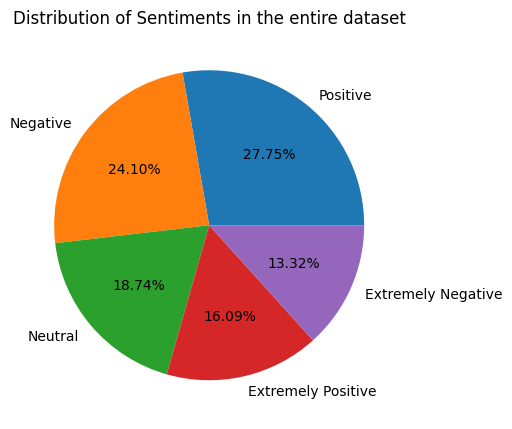

In [ ]:
print(df['Sentiment'].value_counts())

# plot this into a pie chart
plt.rcParams['figure.figsize'] = (5, 10)
plt.pie(df['Sentiment'].value_counts(), labels=df['Sentiment'].value_counts().index, autopct='%1.2f%%')
plt.title("Distribution of Sentiments in the entire dataset")
plt.show()

In [ ]:
X = df['OriginalTweet']
y = df['Sentiment']
pd.set_option('display.max_colwidth', None)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

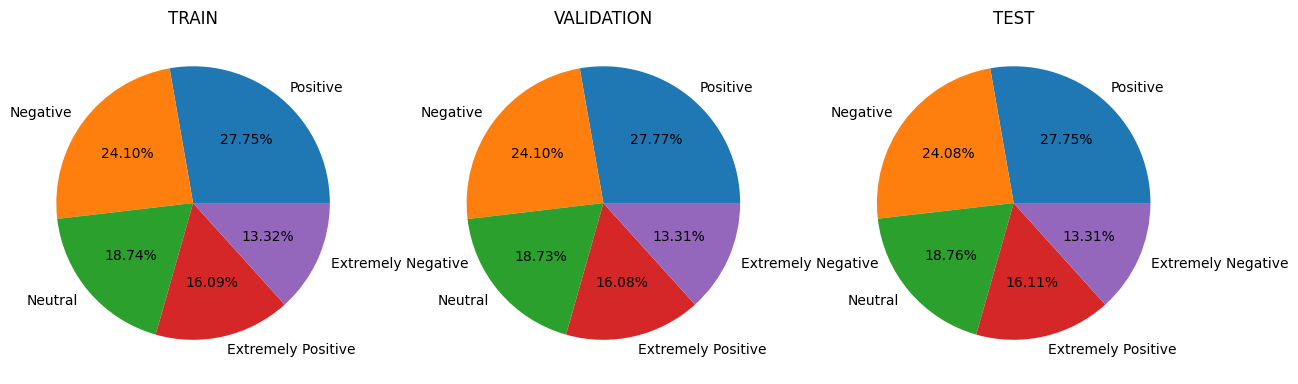

In [ ]:
plt.rcParams['figure.figsize'] = (15, 10)

plt.subplot(1, 3, 1)
plt.pie(pd.Series(y_train).value_counts(), labels=pd.Series(y_train).value_counts().index, autopct='%1.2f%%')
plt.title("TRAIN")

plt.subplot(1, 3, 2)
plt.pie(pd.Series(y_val).value_counts(), labels=pd.Series(y_val).value_counts().index, autopct='%1.2f%%')
plt.title("VALIDATION")

plt.subplot(1, 3, 3)
plt.pie(pd.Series(y_test).value_counts(), labels=pd.Series(y_test).value_counts().index, autopct='%1.2f%%')
plt.title("TEST")
plt.show()

In [ ]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
def remove_unnecessary_elements(text):
    text = text.lower()
    text = re.sub(r'(covid[-_]?19|covid2019|covid[-_]?2019|corona[-_]?virus|corona|covid)', 'covid', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)

    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'\r', ' ', text)
    text = re.sub(r'â|â', "'", text)
    text = re.sub(r'\x92|\xa0|\x85|\x95', '', text)
    text = contractions.fix(text)
    text = re.sub(r'[^\w\s]', ' ', text)

    return text

X_train = np.array([remove_unnecessary_elements(text) for text in X_train])
X_val = np.array([remove_unnecessary_elements(text) for text in X_val])
X_test = np.array([remove_unnecessary_elements(text) for text in X_test])

In [ ]:
# tokenizing without limiting vocabulary size, to get word counts
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(X_train)

word_counts = len(tokenizer.word_index) + 1  # vocabulary size

print("Numbers of unique words present:", word_counts)

Numbers of unique words present: 40273


In [ ]:
train_sequences = tokenizer.texts_to_sequences(X_train)

maxlen = max([len(seq) for seq in train_sequences])
print("Maximum length of all sequences:", maxlen)

padded_train_sequences = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
print("Padded TRAINING Sequences Shape:", padded_train_sequences.shape)

Maximum length of all sequences: 65
Padded TRAINING Sequences Shape: (32925, 65)


In [ ]:
longest_sequence_index = np.argmax([len(seq) for seq in train_sequences])

# Get the longest sequence and its corresponding original sentence
longest_sequence = train_sequences[longest_sequence_index]
longest_sentence = X_train[longest_sequence_index]

print(longest_sentence)

i want to go shopping i want to walk w o the thought i might get the covid virus i want a real hug i want to go eat at a dine in restaurant ohhh to be free w o the thought of that darn virus i want to go shopping for shoes i do not need just want to go shopping   no more online 


In [ ]:
# For Validation set
val_sequences = tokenizer.texts_to_sequences(X_val)
padded_val_sequences = pad_sequences(val_sequences, maxlen=maxlen, padding='post')

print("Padded VALIDATION Sequences Shape:", padded_val_sequences.shape)

Padded VALIDATION Sequences Shape: (4116, 65)


In [ ]:
# For test set
test_sequences = tokenizer.texts_to_sequences(X_test)
padded_test_sequences = pad_sequences(test_sequences, maxlen=maxlen, padding='post')

print("Padded TEST Sequences Shape:", padded_test_sequences.shape)

Padded TEST Sequences Shape: (4116, 65)


In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
import requests, zipfile, io

url = "http://nlp.stanford.edu/data/glove.6B.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("glove_data")


In [ ]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix("glove_data/glove.6B.100d.txt", tokenizer.word_index, embedding_dim)


In [ ]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(f"Percent of vocabulary covered: {round(nonzero_elements/word_counts*100, 2)}%")

Percent of vocabulary covered: 67.51%


In [ ]:
# Get the words that are not covered by GloVe
not_covered_words = []
for word, idx in tokenizer.word_index.items():
    if np.count_nonzero(embedding_matrix[idx]) == 0:  # If the embedding vector is all zeros
        not_covered_words.append(word)

# Print some of the words that are not covered
print(f"Total uncovered words: {len(not_covered_words)}")
print("Sample of uncovered words:", not_covered_words[:50])

Total uncovered words: 13083
Sample of uncovered words: ['covid', 'toiletpaper', 'socialdistancing', 'covidcrisis', 'covidpandemic', 'covidoutbreak', 'coviduk', 'stayhome', 'stayathome', 'stayhomesavelives', 'panicbuying', 'stophoarding', 'covidupdate', 'stoppanicbuying', 'staysafe', 'quarantinelife', 'handsanitizer', 'toiletpaperpanic', 'toiletpapercrisis', 'covidlockdown', 'covidusa', 'covidindia', 'panicbuyinguk', 'sanitiser', 'onlineshopping', 'toiletpaperapocalypse', 'washyourhands', 'supplychain', 'socialdistanacing', 'covidcrisisuk', 'panicshopping', 'covidiots', 'pricegouging', 'selfisolation', 'covidaustralia', 'covidau', 'flattenthecurve', 'stopstockpiling', 'staysafestayhome', 'auspol', 'covidpocolypse', 'covidupdates', 'stockup', 'groceryshopping', 'chinesevirus', 'mrx', 'quaratinelife', 'covidchallenge', 'shelterinplace', 'lockdownuk']


In [ ]:
model = Sequential()

model.add(Embedding(word_counts,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=True))

model.add(SpatialDropout1D(0.3))

model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Bidirectional(LSTM(units=32, return_sequences=False)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(24, activation='relu', kernel_regularizer=l2(0.05)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.05)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.build((padded_train_sequences.shape))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32925, 65, 100)       │     4,027,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (32925, 65, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (32925, 65, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (32925, 65, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32925, 65, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (32925, 64)            │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (32925, 64)            │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32925, 64)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32925, 24)            │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (32925, 24)            │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32925, 24)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32925, 16)            │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (32925, 16)            │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (32925, 16)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32925, 5)             │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,155,969 (15.85 MB)

 Trainable params: 4,155,505 (15.85 MB)

 Non-trainable params: 464 (1.81 KB)

In [ ]:
# Assuming `y_train_original` holds the non-one-hot encoded original sentiment labels
y_train_original = np.argmax(y_train, axis=1)  # Converting one-hot encoded y_train back to label form

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_original), y=y_train_original)
class_weights = dict(enumerate(class_weights))

num_epochs = 10

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0002, clipnorm=1.0),
              metrics = ['accuracy'])

In [ ]:
history = model.fit(padded_train_sequences,
                    y_train,
                    validation_data=(padded_val_sequences, y_val),
                    epochs=num_epochs,
                    class_weight=class_weights,
                    callbacks =[reduce_lr, early_stop, checkpoint],
                    batch_size=32,
                    verbose=1)

Epoch 1/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.2097 - loss: 4.2735
Epoch 1: val_accuracy improved from -inf to 0.27915, saving model to best_model.keras
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 242s 222ms/step - accuracy: 0.2097 - loss: 4.2730 - val_accuracy: 0.2792 - val_loss: 2.8155 - learning_rate: 2.0000e-04
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.2548 - loss: 2.6236
Epoch 2: val_accuracy improved from 0.27915 to 0.31730, saving model to best_model.keras
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 258s 219ms/step - accuracy: 0.2548 - loss: 2.6233 - val_accuracy: 0.3173 - val_loss: 1.9492 - learning_rate: 2.0000e-04
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.2956 - loss: 1.9160
Epoch 3: val_accuracy improved from 0.31730 to 0.37682, saving model to best_model.keras
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 230s 224ms/step - accuracy: 0.2956 - loss: 1.9159 - val_accuracy: 0.3768 - val_loss: 1.5542 - learning_rate: 2.0000e-04
Epoch 4/10
10

In [ ]:
plt.rcParams['figure.figsize'] = (10, 4)

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Load the model from the file
model = load_model('best_model.keras')

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(padded_test_sequences, y_test, verbose=1)
print(f'Test Accuracy: {(test_accuracy * 100):.2f}%')

In [ ]:
# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))